###  Predicting resubmit/returned profiles using machine learning 

Importing all required modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

Loading the dataset using pandas

In [4]:
df = pd.read_excel(r"C:\Users\RameshMisale\Documents\Profile_data.xlsx")

In [5]:
df1 = df

The resubmit stage in datetime format so converting into binary and this is our target variable 

In [6]:
df1['Resubmit'] = pd.to_datetime(df1['Resubmit'])
df1['Resubmit_binary'] = df1['Resubmit'].notnull().astype(int)

Filling the null values 

In [7]:
columns_to_fill = ['rcra_non_haz_exempt','halogens_flag','no_reactivity_flag','layered','viscosity','odor_flag','ph_flag',
    'flash_point_flag','boiling_point_flag','btu_per_lbs','pumpable_waste_flag','polymerizable_flag','benzene_waste_flag',
    'voc_100_ppm','marine_pollutant_flag','origin_code','sds_attached','specific_gravity','benzene_section_flag',
    'max_benzene_flag','benzene_water','prohibited_land_disposal','uts_waste','voc_500_ppm','specialpricing_flag',
    'intercompany_flag','mgp_flag','pa_waste_catogory','debris','compressed_gas','analytical_ind',
    'generatorknowledge_ind','sds_ind','formulary_attached','analytical_attached','sample_provided','mgplock_flag',
    'naics_flag','federal_universal_waste','generator_state_universal_waste']
df1[columns_to_fill] = df1[columns_to_fill].fillna(0, inplace=False)

In [8]:
col = ['water_percentage', 'toc_percentage'] #filling with mean for these 2 columns
df1[col] = df1[col].fillna(df1[col].mean(), inplace=False)
#df1.isnull().sum()

Dropping the object and datatime columns

In [9]:
object_columns = df1.select_dtypes(include=['object','datetime64']).columns
df_dropped_objects = df1.drop(object_columns, axis=1)
# df_dropped_objects.dtypes

Feature selection dropping constant feature

In [10]:
#It will remove the zero variance features

var_thres=VarianceThreshold(threshold=0)
var_thres.fit(df_dropped_objects)

C:\Users\RameshMisale\anaconda3\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
C:\Users\RameshMisale\anaconda3\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:119: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


VarianceThreshold(threshold=0)

Printing the columns with their values which are constants 

In [11]:
constant_columns = [column for column in df_dropped_objects.columns
                    if column not in df_dropped_objects.columns[var_thres.get_support()]]
print(f"Number of constant columns: {len(constant_columns)}")
for feature in constant_columns:
    unique_values = df_dropped_objects[feature].unique()
    print(f"Constant column: {feature}")
    print(f"Unique values: {unique_values}")
    print("\n")


Number of constant columns: 17
Constant column: phenolics_ppm
Unique values: [nan  0.]


Constant column: cylinder_flag
Unique values: [nan  0.]


Constant column: minimum_packaging_requirements
Unique values: [nan]


Constant column: outbound_profile_taxes
Unique values: [nan]


Constant column: inbound_oubound_id_xref
Unique values: [nan]


Constant column: ky_report_physical_state_ind
Unique values: [nan]


Constant column: ky_report_onsite_ind
Unique values: [nan]


Constant column: contract_id
Unique values: [nan]


Constant column: sic_code
Unique values: [nan]


Constant column: pet_chem_flag
Unique values: [nan  0.]


Constant column: pet_chem_actual
Unique values: [nan]


Constant column: cokeoven_flag
Unique values: [ 0. nan]


Constant column: container_size_flag
Unique values: [ 1. nan]


Constant column: waste_type_id
Unique values: [nan]


Constant column: highly_toxic_flag
Unique values: [nan  0.]


Constant column: incin_prep_flag
Unique values: [nan  1.]


Constant col

In [12]:
data = df_dropped_objects.drop(constant_columns,axis=1) #dropped the columns here 

Feature_selection by correlation and dropped the features which are having >80% correlation with each other

In [13]:
def correlation(dataset,threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]>threshold):
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [14]:
corr_features=correlation(data,0.8)
len(set(corr_features))

48

In [15]:
#corr_features

In [16]:
data1=data.drop(corr_features,axis=1) # dropped the correlated features here

In [17]:
data1.shape

(59378, 136)

In [18]:
data1.shape

(59378, 136)

Dropping the columns which are having >90 % of null values

In [19]:
threshold_percentage = 90 
null_percentage = (data1.isnull().sum() / len(data1)) * 100
columns_to_drop = null_percentage[null_percentage > threshold_percentage].index
data1_dropped = data1.drop(columns=columns_to_drop)
#data1_dropped.isnull().sum()

In [20]:
data1_dropped = data1_dropped.fillna(0) #filling the null values with 0
#data1_dropped.isnull().sum() 

In [21]:
dff = data1_dropped.drop(columns=['ReturnCount','DaysAssignReadyForGenSign','profile_id','web_profile_number',
                                  'DaysSubmitToAssign','DaysAssignReadyForGenSign','DaysReadyForGenSignSentForGenSign',
                                  'DaysDocSignReturnedToApproved','container_type_id','DaysInitiatedToSubmitted',
'DaysSentForGenSignToDocSignReturned','vendor_id','ContractID','ldr_class_id','CustomerId','CollectionId',
'HCSId','Recert','is_template_profile_flag','AssignUser_id','status_code_id','source_code_id','form_code_id',
'management_method_code_id','outbound_profile_id','price_type_code_id','parent_profile_id','health_chemical_identity_id',
'flammability_chemical_identity_id','reactivity_chemical_identity_id','process_code_id',
'SalesrepID','InternalCoordinatorID','MarketDriverID','InsideSalesRepID','requested_process_code_id'],axis=1)
dff.shape

(59378, 84)

In [22]:
# # Assuming 'dff' is your DataFrame
# for column in dff.columns:
#     print(column)

In [23]:
# X = dff.drop('Resubmit_binary', axis=1)
# y = dff['Resubmit_binary']
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [24]:
# from sklearn.feature_selection import f_classif,SelectKBest
# fs = SelectKBest(score_func= f_classif,k=10)
#fs.fit(X,y)
#fs.get_support()
#fs.get_support().sum()

In [25]:
# import math
# def list_ceil(x):
#     return[math.ceil(i) for i in x]

In [26]:
# print("P_Value :")
# print(np.round(fs.pvalues_,4))
# print("F Value :")
# print(fs.scores_)
# list_ceil(fs.scores_)
# features_score = pd.DataFrame(fs.scores_)
# features_pvalue = pd.DataFrame(np.round(fs.pvalues_,4))
# features = pd.DataFrame(X.columns)
# feature_score = pd.concat([features,features_score,features_pvalue],axis=1)
# # Assign the column name
# feature_score.columns = ["Input_Features","Score","P_Value"]
# print(feature_score.nlargest(5,columns="Score"))

Checking the VIF value and dropped which are having > 5 VIF value

In [27]:
vif_data = pd.DataFrame()
vif_data["feature"] = dff.columns
vif_data["VIF"] = [variance_inflation_factor(dff.values, i) for i in range(dff.shape[1])]
print(vif_data)

                            feature        VIF
0                             IsHaz  41.992835
1              outbound_profile_ind   1.218593
2                     isRecertified   1.227366
3                     standard_flag  32.184140
4                         rush_flag   4.942465
..                              ...        ...
79                       label_type   2.613335
80          federal_universal_waste   1.663563
81  generator_state_universal_waste   1.115983
82                     revision_num   1.885647
83                  Resubmit_binary   1.245218

[84 rows x 2 columns]


In [28]:
high_vif_columns = vif_data[vif_data["VIF"] > 5]["feature"].tolist()
high_vif_columns

['IsHaz',
 'standard_flag',
 'urgent_flag',
 'toc_percentage',
 'generatorknowledge_ind']

In [29]:
df_final = dff.drop(columns=high_vif_columns)
df_final.shape

(59378, 79)

Checking the correlation for top 10 columns 

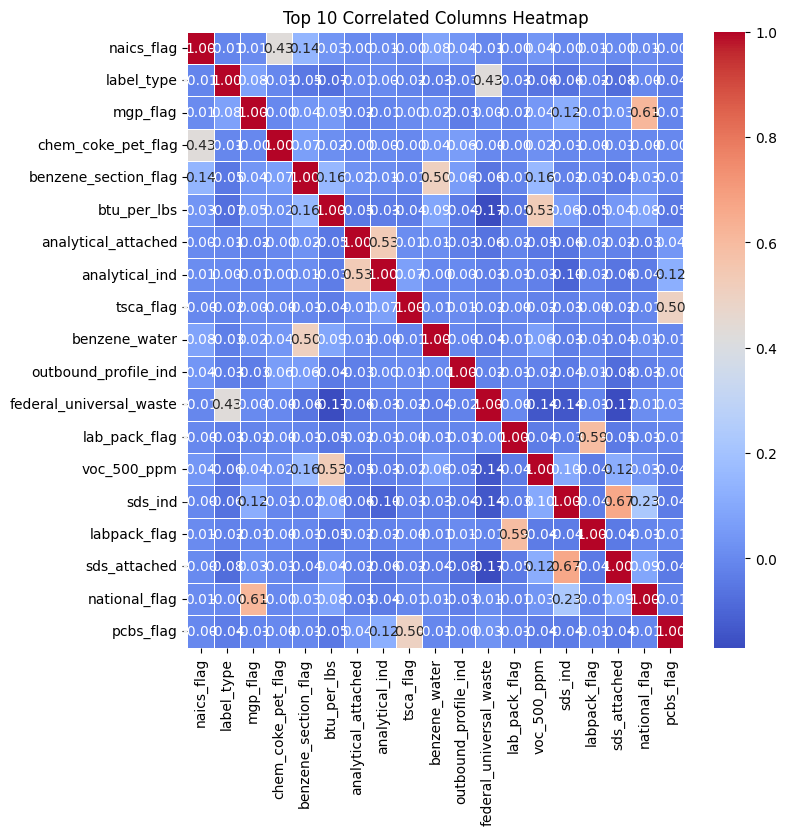

In [30]:

correlation_matrix = df_final.corr()
top_correlations = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates().head(10)
top_correlation_columns = list(set([pair[0] for pair in top_correlations.index] + [pair[1] for pair in top_correlations.index]))
top_correlation_matrix = correlation_matrix.loc[top_correlation_columns, top_correlation_columns]

#Plot the heatmap
plt.figure(figsize=(8,8))
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Top 10 Correlated Columns Heatmap')
plt.show()

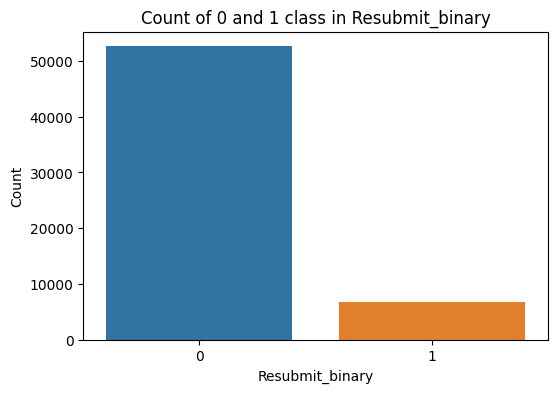

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Resubmit_binary', data=df_final)
plt.title('Count of 0 and 1 class in Resubmit_binary')
plt.xlabel('Resubmit_binary')
plt.ylabel('Count')
plt.show()

In [32]:
X = df_final.drop('Resubmit_binary', axis=1)
y = df_final['Resubmit_binary']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Feature selection using entropy typically involves selecting features based on their information gain or entropy.

In [33]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = pd.Series(mutual_info_classif(X_train, y_train), index=X_train.columns)

# Select top features based on mutual information
top_features = mutual_info.sort_values(ascending=False).head(20).index

# Display top features
print("Top Features based on Mutual Information:")
print(top_features)

Top Features based on Mutual Information:
Index(['sds_attached', 'sds_ind', 'revision_num', 'label_type', 'origin_code',
       'odor_flag', 'viscosity', 'federal_universal_waste', 'flash_point_flag',
       'pumpable_waste_flag', 'halogens_flag', 'voc_500_ppm', 'cyanides_flag',
       'ApprovedTonnage', 'solid_flag', 'voc_100_ppm', 'rcra_non_haz_exempt',
       'btu_per_lbs', 'free_liquids_flag', 'gas_flag'],
      dtype='object')


# Logistic Regression

Buit the model before balancing the dataset

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred_lr_train = logistic_regression.predict(X_train)
y_pred_lr_test = logistic_regression.predict(X_test)

# Accuracy
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print(f'Logistic Regression Training Accuracy: {accuracy_lr_train}')
print(f'Logistic Regression Testing Accuracy: {accuracy_lr_test}')
# classification report
# print(classification_report(y_test, y_pred_lr_test))
# print(confusion_matrix(y_test, y_pred_lr_test)) 

precision_lr_test = precision_score(y_test, y_pred_lr_test)
recall_lr_test = recall_score(y_test, y_pred_lr_test)
f1_lr_test = f1_score(y_test, y_pred_lr_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_lr_test:.4f}')
print(f'Recall: {recall_lr_test:.4f}')
print(f'F1-Score: {f1_lr_test:.4f}')



Logistic Regression Training Accuracy: 0.8873100079996632
Logistic Regression Testing Accuracy: 0.8817783765577636

Precision: 0.4634
Recall: 0.0136
F1-Score: 0.0264


C:\Users\RameshMisale\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
# # ROC-AUC curve
# from sklearn.metrics import roc_curve, auc
# y_prob_lr_test = logistic_regression.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr_test)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(4, 4))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

# DT

In [36]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion='gini',max_depth=5)
decision_tree.fit(X_train, y_train)
y_pred_dt_train = decision_tree.predict(X_train)
y_pred_dt_test = decision_tree.predict(X_test)
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)
print(f'Decision Tree Training Accuracy: {accuracy_dt_train}')
print(f'Decision Tree Testing Accuracy: {accuracy_dt_test}')
# # classification report
# print(classification_report(y_test, y_pred_dt_test))
# print(confusion_matrix(y_test, y_pred_dt_test))

precision_dt_test = precision_score(y_test, y_pred_dt_test)
recall_dt_test = recall_score(y_test, y_pred_dt_test)
f1_dt_test = f1_score(y_test, y_pred_dt_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_dt_test:.4f}')
print(f'Recall: {recall_dt_test:.4f}')
print(f'F1-Score: {f1_dt_test:.4f}')

Decision Tree Training Accuracy: 0.8880678708264915
Decision Tree Testing Accuracy: 0.8816941731222634

Precision: 0.4412
Recall: 0.0107
F1-Score: 0.0209


# Random Forest

In [37]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_rf_train = random_forest.predict(X_train)
y_pred_rf_test = random_forest.predict(X_test)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print(f'Random Forest Training Accuracy: {accuracy_rf_train}')
print(f'Random Forest Testing Accuracy: {accuracy_rf_test}')

# classification report
# print(classification_report(y_test, y_pred_rf_test))
# print(confusion_matrix(y_test, y_pred_rf_test))

precision_rf_test = precision_score(y_test, y_pred_rf_test)
recall_rf_test = recall_score(y_test, y_pred_rf_test)
f1_rf_test = f1_score(y_test, y_pred_rf_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_rf_test:.4f}')
print(f'Recall: {recall_rf_test:.4f}')
print(f'F1-Score: {f1_rf_test:.4f}')

Random Forest Training Accuracy: 0.9755589238347859
Random Forest Testing Accuracy: 0.8768945772987538

Precision: 0.4173
Recall: 0.1099
F1-Score: 0.1740


#  Under-sampling

In [38]:
XX = df_final.drop('Resubmit_binary', axis='columns')
yy= df_final['Resubmit_binary']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy, test_size=0.2,random_state=42,stratify=yy)

In [39]:
count_0_class,count_1_class = df_final.Resubmit_binary.value_counts()
df_class_0 = df_final[df_final["Resubmit_binary"]==0]
df_class_1 = df_final[df_final["Resubmit_binary"]==1]
X_train, X_test, y_train, y_test = train_test_split(XX,yy, test_size=0.2,random_state=15,stratify=yy)

In [40]:
# count_0_class_under = int(count_0_class*0.2)
# df_class_0_under = df_class_0.sample(count_0_class_under)
# df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

# print('Random Under-sampling:')
# print(df_test_under.Resubmit_binary.value_counts())

In [41]:
df_class_0.shape

(52621, 79)

In [42]:
df_class_1.shape

(6757, 79)

In [43]:
count_0_class,count_1_class

(52621, 6757)

In [44]:
df_class_0_under = df_class_0.sample(count_1_class)
df_test_under = pd.concat([df_class_0_under, df_class_1],axis=0)

print('Random Under-sampling:')
print(df_test_under.Resubmit_binary.value_counts())

Random Under-sampling:
0    6757
1    6757
Name: Resubmit_binary, dtype: int64


In [45]:
XX = df_test_under.drop('Resubmit_binary', axis='columns')
yy= df_test_under['Resubmit_binary']
XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy, test_size=0.2,random_state=42,stratify=yy)

In [46]:
yy_train.value_counts()

1    5406
0    5405
Name: Resubmit_binary, dtype: int64

In [47]:
yy_test.value_counts()

0    1352
1    1351
Name: Resubmit_binary, dtype: int64

# Logistic_regression

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score
logistic_regression = LogisticRegression()
logistic_regression.fit(XX_train, yy_train)
y_pred_lr_train = logistic_regression.predict(XX_train)
y_pred_lr_test = logistic_regression.predict(XX_test)

# Accuracy
accuracy_lr_train = accuracy_score(yy_train, y_pred_lr_train)
accuracy_lr_test = accuracy_score(yy_test, y_pred_lr_test)
print(f'Logistic Regression Training Accuracy: {accuracy_lr_train}')
print(f'Logistic Regression Testing Accuracy: {accuracy_lr_test}')

# # classification report
# print(classification_report(yy_test, y_pred_lr_test))
# print(confusion_matrix(yy_test, y_pred_lr_test))

precision_lr_test = precision_score(yy_test, y_pred_lr_test)
recall_lr_test = recall_score(yy_test, y_pred_lr_test)
f1_lr_test = f1_score(yy_test, y_pred_lr_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_lr_test:.4f}')
print(f'Recall: {recall_lr_test:.4f}')
print(f'F1-Score: {f1_lr_test:.4f}')


Logistic Regression Training Accuracy: 0.6937378595874573
Logistic Regression Testing Accuracy: 0.7018128005919348

Precision: 0.6891
Recall: 0.7350
F1-Score: 0.7113


C:\Users\RameshMisale\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


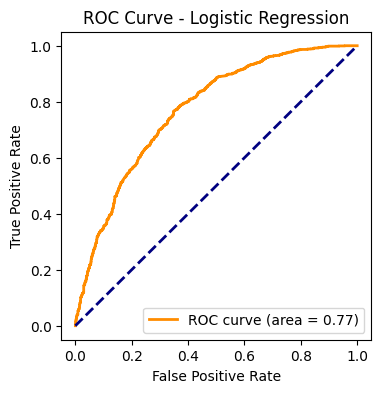

In [49]:
# ROC-AUC curve
from sklearn.metrics import roc_curve, auc
y_prob_lr_test = logistic_regression.predict_proba(XX_test)[:, 1]
fpr, tpr, thresholds = roc_curve(yy_test, y_prob_lr_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Decision_tree

In [50]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='gini',max_depth=5)
decision_tree.fit(XX_train, yy_train)
y_pred_dt_train = decision_tree.predict(XX_train)
y_pred_dt_test = decision_tree.predict(XX_test)
accuracy_dt_train = accuracy_score(yy_train, y_pred_dt_train)
accuracy_dt_test = accuracy_score(yy_test, y_pred_dt_test)
print(f'Decision Tree Training Accuracy: {accuracy_dt_train}')
print(f'Decision Tree Testing Accuracy: {accuracy_dt_test}')

# classification report
print(classification_report(yy_test, y_pred_dt_test))
print(confusion_matrix(yy_test, y_pred_dt_test))


precision_dt_test = precision_score(yy_test, y_pred_dt_test)
recall_dt_test = recall_score(yy_test, y_pred_dt_test)
f1_dt_test = f1_score(yy_test, y_pred_dt_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_dt_test:.4f}')
print(f'Recall: {recall_dt_test:.4f}')
print(f'F1-Score: {f1_dt_test:.4f}')

Decision Tree Training Accuracy: 0.6910554065303857
Decision Tree Testing Accuracy: 0.7029226785053644
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1352
           1       0.71      0.69      0.70      1351

    accuracy                           0.70      2703
   macro avg       0.70      0.70      0.70      2703
weighted avg       0.70      0.70      0.70      2703

[[967 385]
 [418 933]]

Precision: 0.7079
Recall: 0.6906
F1-Score: 0.6991


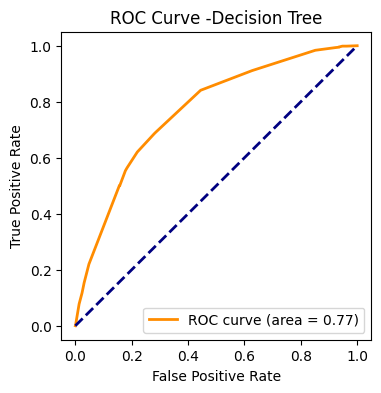

In [51]:
# ROC-AUC curve
from sklearn.metrics import roc_curve, auc
y_prob_dt_test = decision_tree.predict_proba(XX_test)[:, 1]
fpr, tpr, thresholds = roc_curve(yy_test, y_prob_dt_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -Decision Tree')
plt.legend(loc='lower right')
plt.show()

# Random_forest

In [52]:
random_forest1 = RandomForestClassifier(n_estimators=100,max_depth=10,criterion='gini')
random_forest1.fit(XX_train, yy_train)
y_pred_rf_train = random_forest1.predict(XX_train)
y_pred_rf_test = random_forest1.predict(XX_test)
accuracy_rf_train = accuracy_score(yy_train, y_pred_rf_train)
accuracy_rf_test = accuracy_score(yy_test, y_pred_rf_test)
print(f'Random Forest Training Accuracy: {accuracy_rf_train}')
print(f'Random Forest Testing Accuracy: {accuracy_rf_test}')
# # classification report
# print(classification_report(yy_test, y_pred_rf_test))
# print(confusion_matrix(yy_test, y_pred_rf_test))

precision_rf_test = precision_score(yy_test, y_pred_rf_test)
recall_rf_test = recall_score(yy_test, y_pred_rf_test)
f1_rf_test = f1_score(yy_test, y_pred_rf_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_rf_test:.4f}')
print(f'Recall: {recall_rf_test:.4f}')
print(f'F1-Score: {f1_rf_test:.4f}')

Random Forest Training Accuracy: 0.7430394968088059
Random Forest Testing Accuracy: 0.7321494635590086

Precision: 0.7219
Recall: 0.7550
F1-Score: 0.7381


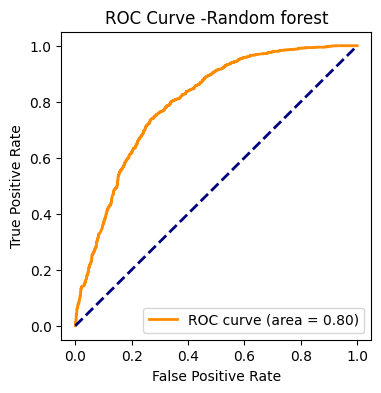

In [53]:
# ROC-AUC curve
from sklearn.metrics import roc_curve, auc
y_prob_rf_test = random_forest1.predict_proba(XX_test)[:, 1]
fpr, tpr, thresholds = roc_curve(yy_test, y_prob_rf_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -Random forest')
plt.legend(loc='lower right')
plt.show()

# Gaussian Naive Bayes classifier

In [54]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(XX_train, yy_train)
y_pred_nb_train = naive_bayes.predict(XX_train)
y_pred_nb_test = naive_bayes.predict(XX_test)

# Accuracy
accuracy_nb_train = accuracy_score(yy_train, y_pred_nb_train)
accuracy_nb_test = accuracy_score(yy_test, y_pred_nb_test)
print(f'Naive Bayes Training Accuracy: {accuracy_nb_train:.4f}')
print(f'Naive Bayes Testing Accuracy: {accuracy_nb_test:.4f}')

# Precision, Recall, and F1-Score
precision_nb_test = precision_score(yy_test, y_pred_nb_test)
recall_nb_test = recall_score(yy_test, y_pred_nb_test)
f1_nb_test = f1_score(yy_test, y_pred_nb_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_nb_test:.4f}')
print(f'Recall: {recall_nb_test:.4f}')
print(f'F1-Score: {f1_nb_test:.4f}')


Naive Bayes Training Accuracy: 0.6071
Naive Bayes Testing Accuracy: 0.6067

Precision: 0.5629
Recall: 0.9541
F1-Score: 0.7080


# KNeighborsClassifier

In [55]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors = 7
knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_classifier.fit(XX_train, yy_train)
y_pred_knn_train = knn_classifier.predict(XX_train)

# Predictions on the test set
y_pred_knn_test = knn_classifier.predict(XX_test)

# Accuracy
accuracy_knn_train = accuracy_score(yy_train, y_pred_knn_train)
accuracy_knn_test = accuracy_score(yy_test, y_pred_knn_test)
print(f'KNN Training Accuracy: {accuracy_knn_train:.4f}')
print(f'KNN Testing Accuracy: {accuracy_knn_test:.4f}')

# Precision, Recall, and F1-Score
precision_knn_test = precision_score(yy_test, y_pred_knn_test)
recall_knn_test = recall_score(yy_test, y_pred_knn_test)
f1_knn_test = f1_score(yy_test, y_pred_knn_test)

# Display precision, recall, and f1-score
print(f'\nPrecision: {precision_knn_test:.4f}')
print(f'Recall: {recall_knn_test:.4f}')
print(f'F1-Score: {f1_knn_test:.4f}')


KNN Training Accuracy: 0.7398
KNN Testing Accuracy: 0.6667

Precision: 0.6539
Recall: 0.7076
F1-Score: 0.6797


In [72]:
#!pip install pycaret --user

In [73]:
#!pip install pycaret

In [183]:
# import os
# from pycaret.classification import *
# clf1 = setup(data=df_test_under, target='Resubmit_binary')
# best_model = compare_models()
# print(best_model)
# final_model = create_model(best_model)
# evaluate_model(final_model)


# Feature importance

Feature importance is a concept used in machine learning to quantify the impact or contribution of each feature (or variable) in a predictive model. 
It provides insights into which features are most influential in making predictions.

Features with higher importance values are considered more influential in predicting the target variable.

In [ ]:
#feature_importance= dict(zip(random_forest.feature_names_in_,[round(i,4) for i in random_forest.feature_importances_]))
# select the top 10 features and give it to the model top 20, top30  store in 3 dataframes 

In [56]:
feature_importance_dict = dict(zip(random_forest1.feature_names_in_, [round(i, 4) for i in random_forest1.feature_importances_]))
threshold = 0.01
selected_features = [feature for feature, importance in feature_importance_dict.items() if importance > threshold]
print("Selected Features:")
print(selected_features)
df_features = pd.DataFrame(data={feature: X[feature] for feature in selected_features})
print("\nDataFrame with Selected Features:")
df_features

Selected Features:
['outbound_profile_ind', 'isRecertified', 'rush_flag', 'rcra_non_haz_exempt', 'halogens_flag', 'solid_flag', 'free_liquids_flag', 'viscosity', 'odor_flag', 'flash_point_flag', 'btu_per_lbs', 'pumpable_waste_flag', 'voc_100_ppm', 'ApprovedTonnage', 'origin_code', 'sds_attached', 'specific_gravity', 'prohibited_land_disposal', 'voc_500_ppm', 'national_flag', 'pa_waste_catogory', 'water_percentage', 'sds_ind', 'analytical_attached', 'label_type', 'federal_universal_waste', 'revision_num']

DataFrame with Selected Features:


,outbound_profile_ind,isRecertified,rush_flag,rcra_non_haz_exempt,halogens_flag,solid_flag,free_liquids_flag,viscosity,odor_flag,flash_point_flag,...,prohibited_land_disposal,voc_500_ppm,national_flag,pa_waste_catogory,water_percentage,sds_ind,analytical_attached,label_type,federal_universal_waste,revision_num
0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,...,0.0,0.0,0.0,0.0,60.000000,1.0,0.0,1.0,0.0,1
1,0,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,7.0,10.000000,1.0,0.0,1.0,0.0,1
2,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.000000,1.0,0.0,3.0,0.0,1
3,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.529263,0.0,0.0,0.0,0.0,0
4,0,1,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,...,1.0,0.0,0.0,5.0,0.000000,1.0,0.0,7.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59373,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,12.529263,1.0,0.0,1.0,0.0,0
59374,0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,50.000000,1.0,0.0,1.0,0.0,0
59375,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,7.0,1.0,3
59376,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,48.000000,1.0,0.0,1.0,0.0,0


In [57]:

feature_importance_dict = dict(zip(random_forest1.feature_names_in_, [round(i, 4) for i in random_forest1.feature_importances_]))
threshold = 0.01
selected_features = [feature for feature, importance in feature_importance_dict.items() if importance > threshold]
top10_features = sorted(selected_features, key=lambda x: feature_importance_dict[x], reverse=True)[:10]
print("Top 10 Features:")
print(top10_features)
df_top10_features = pd.DataFrame(data={feature: X[feature] for feature in top10_features})
# print("\nDataFrame with Top 10 Features:")
# df_top10_features

Top 10 Features:
['sds_attached', 'revision_num', 'sds_ind', 'federal_universal_waste', 'odor_flag', 'label_type', 'water_percentage', 'ApprovedTonnage', 'flash_point_flag', 'solid_flag']


In [58]:

feature_importance_dict = dict(zip(random_forest1.feature_names_in_, [round(i, 4) for i in random_forest1.feature_importances_]))
threshold = 0.01
selected_features = [feature for feature, importance in feature_importance_dict.items() if importance > threshold]
top20_features = sorted(selected_features, key=lambda x: feature_importance_dict[x], reverse=True)[:20]
print("Top 20 Features:")
print(top20_features)
df_top20_features = pd.DataFrame(data={feature: X[feature] for feature in top20_features})
# print("\nDataFrame with Top 20 Features:")
# df_top20_features

Top 20 Features:
['sds_attached', 'revision_num', 'sds_ind', 'federal_universal_waste', 'odor_flag', 'label_type', 'water_percentage', 'ApprovedTonnage', 'flash_point_flag', 'solid_flag', 'btu_per_lbs', 'analytical_attached', 'free_liquids_flag', 'isRecertified', 'pumpable_waste_flag', 'viscosity', 'origin_code', 'voc_500_ppm', 'pa_waste_catogory', 'prohibited_land_disposal']


In [59]:

feature_importance_dict = dict(zip(random_forest1.feature_names_in_, [round(i, 4) for i in random_forest1.feature_importances_]))
threshold = 0.01
selected_features = [feature for feature, importance in feature_importance_dict.items() if importance > threshold]
top30_features = sorted(selected_features, key=lambda x: feature_importance_dict[x], reverse=True)[:30]
print("Top 30 Features:")
print(top30_features)
df_top30_features = pd.DataFrame(data={feature: X[feature] for feature in top30_features})
# print("\nDataFrame with Top 30 Features:")
# df_top30_features

Top 30 Features:
['sds_attached', 'revision_num', 'sds_ind', 'federal_universal_waste', 'odor_flag', 'label_type', 'water_percentage', 'ApprovedTonnage', 'flash_point_flag', 'solid_flag', 'btu_per_lbs', 'analytical_attached', 'free_liquids_flag', 'isRecertified', 'pumpable_waste_flag', 'viscosity', 'origin_code', 'voc_500_ppm', 'pa_waste_catogory', 'prohibited_land_disposal', 'outbound_profile_ind', 'specific_gravity', 'national_flag', 'rcra_non_haz_exempt', 'rush_flag', 'halogens_flag', 'voc_100_ppm']


In [60]:
df_top10_features.shape

(59378, 10)

In [61]:
df_final.shape

(59378, 79)

In [62]:
count_0_class,count_1_class = df_final.Resubmit_binary.value_counts()
df_class_0 = df_final[df_final["Resubmit_binary"]==0]
df_class_1 = df_final[df_final["Resubmit_binary"]==1]
X_train, X_test, y_train, y_test = train_test_split(XX,yy, test_size=0.2,random_state=15,stratify=yy)

In [63]:
df_class_0_under = df_class_0.sample(count_1_class)
df_top30_features = pd.concat([df_class_0_under, df_class_1],axis=0)

print('Random Under-sampling:')
print(df_test_under.Resubmit_binary.value_counts())

Random Under-sampling:
0    6757
1    6757
Name: Resubmit_binary, dtype: int64


In [64]:
X_top30 = df_top30_features[top20_features]
yy = df_test_under['Resubmit_binary'] 

XX_train, XX_test, yy_train, yy_test = train_test_split(X_top30, yy, test_size=0.2, random_state=42,stratify=yy)
logistic_regression = LogisticRegression(penalty='l2',C=1.0,max_iter=100,random_state=42)
logistic_regression.fit(XX_train, yy_train)
y_pred = logistic_regression.predict(XX_test)
accuracy = accuracy_score(yy_test, y_pred)
classification_report_str = classification_report(yy_test, y_pred)
confusion_mat = confusion_matrix(yy_test, y_pred)

precision_knn_test = precision_score(yy_test, y_pred_knn_test)
recall_knn_test = recall_score(yy_test, y_pred_knn_test)
f1_knn_test = f1_score(yy_test, y_pred_knn_test)

print(f'\nPrecision: {precision_knn_test:.4f}')
print(f'Recall: {recall_knn_test:.4f}')
print(f'F1-Score: {f1_knn_test:.4f}')
print(f'Logistict regression accuracy for top 30 columns:{accuracy}')


Precision: 0.6539
Recall: 0.7076
F1-Score: 0.6797
Logistict regression accuracy for top 30 columns:0.6796152423233445


C:\Users\RameshMisale\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
from sklearn.tree import DecisionTreeClassifier
XX_train, XX_test, yy_train, yy_test = train_test_split(X_top30, yy, test_size=0.2, random_state=42, stratify=yy)
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(XX_train, yy_train)
y_pred = decision_tree.predict(XX_test)
accuracy = accuracy_score(yy_test, y_pred)
classification_report_str = classification_report(yy_test, y_pred)
confusion_mat = confusion_matrix(yy_test, y_pred)

precision_dt_test = precision_score(yy_test, y_pred)
recall_dt_test = recall_score(yy_test, y_pred)
f1_dt_test = f1_score(yy_test, y_pred)

print(f'\nPrecision: {precision_dt_test:.4f}')
print(f'Recall: {recall_dt_test:.4f}')
print(f'F1-Score: {f1_dt_test:.4f}')
print(f'Decision Tree accuracy for top 30 columns: {accuracy}')


Precision: 0.6401
Recall: 0.6003
F1-Score: 0.6196
Decision Tree accuracy for top 30 columns: 0.6315205327413984


In [67]:
from sklearn.ensemble import RandomForestClassifier
XX_train, XX_test, yy_train, yy_test = train_test_split(X_top30, yy, test_size=0.2, random_state=42, stratify=yy)

random_forest_ = RandomForestClassifier(n_estimators=100,max_depth=10,criterion='gini')
random_forest_.fit(XX_train, yy_train)
y_pred = random_forest.predict(XX_test)

accuracy = accuracy_score(yy_test, y_pred)
classification_report_str = classification_report(yy_test, y_pred)
confusion_mat = confusion_matrix(yy_test, y_pred)

precision_rf_test = precision_score(yy_test, y_pred)
recall_rf_test = recall_score(yy_test, y_pred)
f1_rf_test = f1_score(yy_test, y_pred)

print(f'\nPrecision: {precision_rf_test:.4f}')
print(f'Recall: {recall_rf_test:.4f}')
print(f'F1-Score: {f1_rf_test:.4f}')
print(f'Random Forest accuracy for top 30 columns: {accuracy}')



Precision: 0.6933
Recall: 0.7698
F1-Score: 0.7296
Random Forest accuracy for top 30 columns: 0.7147613762486127


In [70]:
import pickle
file_path = r'C:\Users\RameshMisale\Downloads\random_forest_model.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(random_forest_,file)

import joblib
model_case = joblib.load(open(r'C:\Users\RameshMisale\Downloads\random_forest_model.pkl', 'rb'))
joblib.dump(model_case, r'C:\Users\RameshMisale\Downloads\random_forest_model.pkl')

['C:\\Users\\RameshMisale\\Downloads\\random_forest_model.pkl']

In [ ]:
# df_top_10 = df_top10_features[top10_features]

# # Set the figure size
# plt.figure(figsize=(16, 8))

# # Plot boxplots for the top 10 features
# sns.boxplot(data=df_top_10)
# plt.title('Boxplot of Top 10 Features')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

In [ ]:
# df_top_30 = df_top30_features[top30_features]

# # Set the figure size
# plt.figure(figsize=(18, 8))

# # Plot boxplots for the top 10 features
# sns.boxplot(data=df_top_30)
# plt.title('Boxplot of Top 10 Features')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

In [ ]:
# df_top_20 = df_top20_features[top20_features]

# # Set the figure size
# plt.figure(figsize=(18, 8))

# # Plot boxplots for the top 10 features
# sns.boxplot(data=df_top_20)
# plt.title('Boxplot of Top 10 Features')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

# Over sampling

In [ ]:
# count_0_class,count_1_class = df_final.Resubmit_binary.value_counts()
# df_class_0 = df_final[df_final["Resubmit_binary"]==0]
# df_class_1 = df_final[df_final["Resubmit_binary"]==1]
# #X_train, X_test, y_train, y_test = train_test_split(XX,yy, test_size=0.2,random_state=15,stratify=yy)

In [ ]:
# df_class_1_over = df_class_1.sample(count_0_class,replace=True)

# df_test_over = pd.concat([df_class_0, df_class_1_over],axis=0)
# print('Random Under-sampling:')
# print(df_test_over.Resubmit_binary.value_counts())

In [ ]:
# count_1_class_over = int(count_0_class*0.8)
# df_class_1_over = df_class_1.sample(count_1_class_over, replace=True)
# df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

# print('Random Over-sampling:')
# print(df_test_over.Resubmit_binary.value_counts())

In [ ]:
# XX = df_test_over.drop('Resubmit_binary', axis='columns')
# yy= df_test_over['Resubmit_binary']
# XX_train, XX_test, yy_train, yy_test = train_test_split(XX,yy, test_size=0.2,random_state=42,stratify=yy)

In [ ]:
# yy_train.value_counts()

In [ ]:
# yy_test.value_counts()

# Logistic Regression

In [ ]:
# logistic_regression = LogisticRegression()
# logistic_regression.fit(XX_train, yy_train)
# y_pred_lr_train = logistic_regression.predict(XX_train)
# y_pred_lr_test = logistic_regression.predict(XX_test)

# # Accuracy
# accuracy_lr_train = accuracy_score(yy_train, y_pred_lr_train)
# accuracy_lr_test = accuracy_score(yy_test, y_pred_lr_test)
# print(f'Logistic Regression Training Accuracy: {accuracy_lr_train}')
# print(f'Logistic Regression Testing Accuracy: {accuracy_lr_test}')

# # classification report
# print(classification_report(yy_test, y_pred_lr_test))
# print(confusion_matrix(yy_test, y_pred_lr_test))

In [ ]:
# y_prob_lr_test = logistic_regression.predict_proba(XX_test)[:, 1]

# # ROC-AUC curve
# fpr, tpr, thresholds = roc_curve(yy_test, y_prob_lr_test)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(4, 4))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

# DT

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# decision_tree = DecisionTreeClassifier(criterion='gini',max_depth=5)
# decision_tree.fit(XX_train, yy_train)
# y_pred_dt_train = decision_tree.predict(XX_train)
# y_pred_dt_test = decision_tree.predict(XX_test)
# accuracy_dt_train = accuracy_score(yy_train, y_pred_dt_train)
# accuracy_dt_test = accuracy_score(yy_test, y_pred_dt_test)
# print(f'Decision Tree Training Accuracy: {accuracy_dt_train}')
# print(f'Decision Tree Testing Accuracy: {accuracy_dt_test}')


# # classification report
# print(classification_report(yy_test, y_pred_dt_test))
# print(confusion_matrix(yy_test, y_pred_dt_test))

# Random Forest

In [ ]:
# random_forest = RandomForestClassifier()
# random_forest.fit(XX_train, yy_train)
# y_pred_rf_train = random_forest.predict(XX_train)
# y_pred_rf_test = random_forest.predict(XX_test)
# accuracy_rf_train = accuracy_score(yy_train, y_pred_rf_train)
# accuracy_rf_test = accuracy_score(yy_test, y_pred_rf_test)
# print(f'Random Forest Training Accuracy: {accuracy_rf_train}')
# print(f'Random Forest Testing Accuracy: {accuracy_rf_test}')

# # classification report
# print(classification_report(yy_test, y_pred_rf_test))
# print(confusion_matrix(yy_test, y_pred_rf_test))

In [ ]:
# y_prob_rf_test = logistic_regression.predict_proba(XX_test)[:, 1]

# # ROC-AUC curve
# fpr, tpr, thresholds = roc_curve(yy_test, y_prob_rf_test)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(4, 4))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
#build the model with 82 columns check the accuracy for 3 models----------------------------done 
#plot the distribution of data for class_0,class_1  ----------------------------------------done 
#plot the boxplot and check the outliers ---------------------------------------------------done
#the select top10 20 30 and then build the model check the accuracy for 3 model--------------pending
#plot heatmap for top 10 20 30 -------------------------------------------------------------done 
# after building the model try to do the tuning manually for 3 models------------------------done
#after building the 3 models try others models as well--------------------------------------done
#mention the dropped constant colums with their values -------------------------------------done 
#plot a confusion metrics for precision recall f1-score------------------------------------done
#for feature selection do the entropy - top10,20,30-----------------------------------------done